In [25]:
import astropy as ap
import galsim as gs
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns

# Setup for plotting
%matplotlib inline
import matplotlib.pyplot as plt

#plt.style.use('seaborn-notebook')
sns.set_style('darkgrid')
mpl.rcParams['figure.dpi'] = 160
sns.set(rc={'axes.facecolor': '0.85', 'figure.facecolor': 'w'})

In [26]:
with open(os.path.expanduser("~/raid/lsst/cosmos/cosmos_25.2_training_fits_0_200.pickle.dat"), 'rb') as f:
    data = pickle.load(f)

In [27]:
path = '/r0/taranu/hsc/cosmos/COSMOS_25.2_training_sample/'
file = "real_galaxy_catalog_25.2.fits"
ccat = gs.COSMOSCatalog(file, dir=path)
rgcfits = ap.io.fits.open(os.path.join(path, file))[1].data

In [5]:
# See https://github.com/GalSim-developers/GalSim/blob/8d9bc8ce568e3fa791ab658650fce592cdf03735/galsim/scene.py
# lines 615-625
# Presumably copypasta from the original COSMOS fit catalog table/paper

#     SERSICFIT[0]: intensity of light profile at the half-light radius.
#     SERSICFIT[1]: half-light radius measured along the major axis, in units of pixels
#                   in the COSMOS lensing data reductions (0.03 arcsec).
#     SERSICFIT[2]: Sersic n.
#     SERSICFIT[3]: q, the ratio of minor axis to major axis length.
#     SERSICFIT[4]: boxiness, currently fixed to 0, meaning isophotes are all
#                   elliptical.
#     SERSICFIT[5]: x0, the central x position in pixels.
#     SERSICFIT[6]: y0, the central y position in pixels.
#     SERSICFIT[7]: phi, the position angle in radians.  If phi=0, the major axis is
#                   lined up with the x axis of the image.

params = {
    "cosmos": ["IDENT", "mag_auto", "flux_radius", "zphot", "use_bulgefit", "viable_sersic"],
    "profit": ["chisqred", "time"],
}
idxparamscosmos = [[x + offset for x in [1, 2, 3, 7, 5, 6]] for offset in [0, 8]]
idxprofit = [2, 4, 7, 5, 6, 0, 1]
idxprofittwo = [3, 4, 7, 5, 6, 0, 1, 8, 9, 12, 10, 11, 0, 1]
idxprofitunlog = range(4)
idxprofitunlogtwo = list(np.concatenate([np.arange(4), 7 + np.arange(4)]))
idxparamsprofit = {
    "gauss": (idxprofit, idxprofitunlog),
    "exp": (idxprofit, idxprofitunlog),
    "multidev": (idxprofit, idxprofitunlog),
    "ser": (idxprofit, idxprofitunlog),
    "cmodel": (idxprofittwo, idxprofitunlogtwo),
    "devexp": (idxprofittwo, idxprofitunlogtwo),
}
paramsser = ["flux", "re", "n", "q", "phi", "x0", "y0"]
models = {
    "single": {
        "cosmos": ["ser"],
        "profit": ["gauss", "exp", "multidev", "ser"],
    },
    "double": {
        "cosmos": ["devexp"],
        "profit": ["cmodel", "devexp"],
    },
}
colnames = {
    modeller: [".".join([model, param]) for model in models["single"][modeller] for param in paramsser] +
              [".".join([model, param]) for model in models["double"][modeller] for param in
               [comp + "." + param for comp in ["exp", "dev"] for param in paramsser]]
    for modeller in ["cosmos", "profit"]
}
colnames = (["id", "ra", "dec"] +
            [".".join(["cosmos", param]) for param in params["cosmos"]] +
            [".".join(["profit", model, param, str(idx)]) for model in idxparamsprofit.keys()
             for param in params["profit"] for idx in range(1 + (model != "cmodel"))] +
            [".".join([prefix, x]) for prefix, colnames in colnames.items() for x in colnames])

In [6]:
# Some hideous code to get all of the right values in the right order, for which I apologize

# The COSMOS catalog has fewer objects than the RealGalaxyCatalog for ??? reasons
# Get the mapping between RGC indices (which is what I used) and CosmosCat ones (for previous fits)
indexmap = {ccat.getOrigIndex(i): i for i in range(len(ccat))}

rows = []
for idx in data:
    if isinstance(data[idx], dict) and idx in indexmap:
        row = [idx] + list(rgcfits[idx][1:3])
        rec = ccat.getParametricRecord(indexmap[idx])
        profit = data[idx]['fits']
        row += [rec[param] for param in params["cosmos"]]
        for model in idxparamsprofit:
            profitmodel = profit[model]['fits']['galsim']
            row += [profitmodelfit[param] for param in params["profit"] for profitmodelfit in profitmodel]
        row += [rec["flux"][0]] + list(rec["sersicfit"][idxparamscosmos[0]])
        for offset in range(2):
            row += [rec["flux"][1+offset]] + list(rec["bulgefit"][idxparamscosmos[offset]])
        # The correct way to do this would be to take all of the values and undo the transformations
        # This is possible but for expediency I am not doing it
        for model, idxnser in idxparamsprofit.items():
            twocomp = model == "cmodel" or model == "devexp"
            values = np.array(profit[model]['fits']['galsim'][model != "cmodel"]["paramsbestall"])
            flux = 10**values[2] if twocomp else None
            values = values[idxnser[0]]
            values[idxnser[1]] = 10**values[idxnser[1]]
            if twocomp:
                values[7] = values[7] - values[0]
                for col in [0, 7]:
                    values[col] *= flux
            row += list(values)
        rows.append(row)
        
    # TODO: Convert mu_re into flux for use_bulgefit=0
    #row += profit["paramsbest"]

In [8]:
import csv

with open(os.path.join(path, "galfits.csv"), "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows([colnames])
    writer.writerows(rows)

In [9]:
tab = pd.read_csv(os.path.join(path, "galfits.csv"))

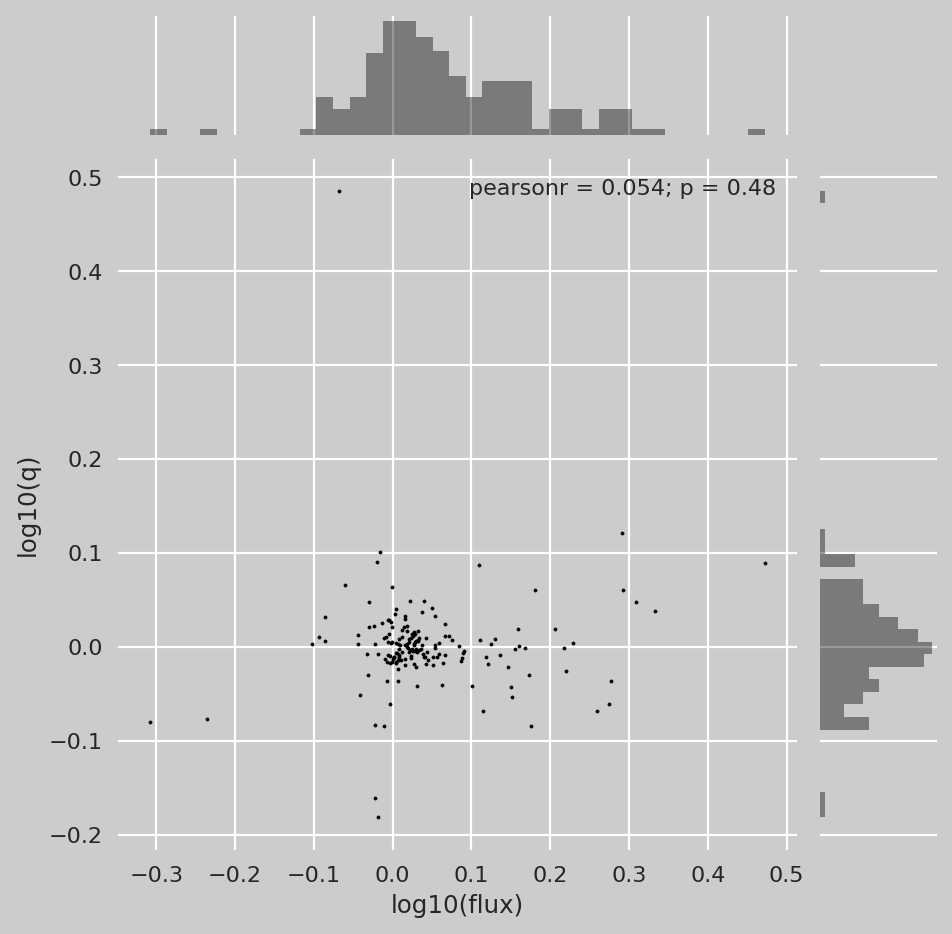

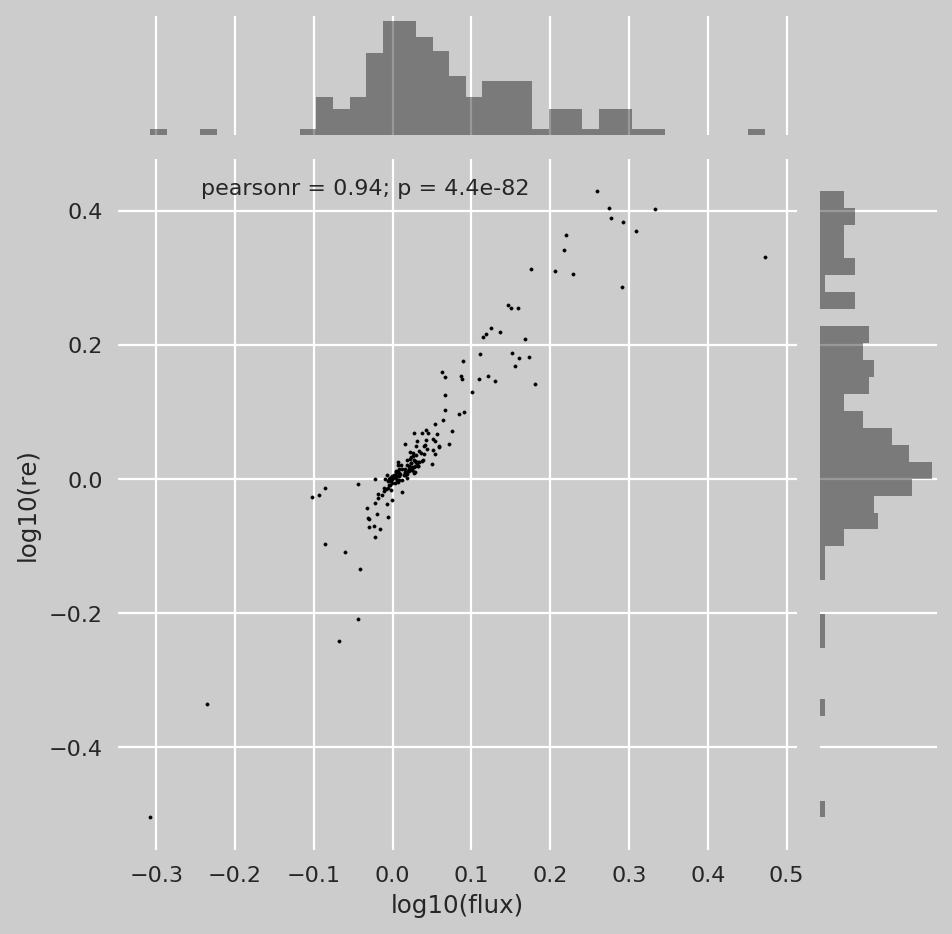

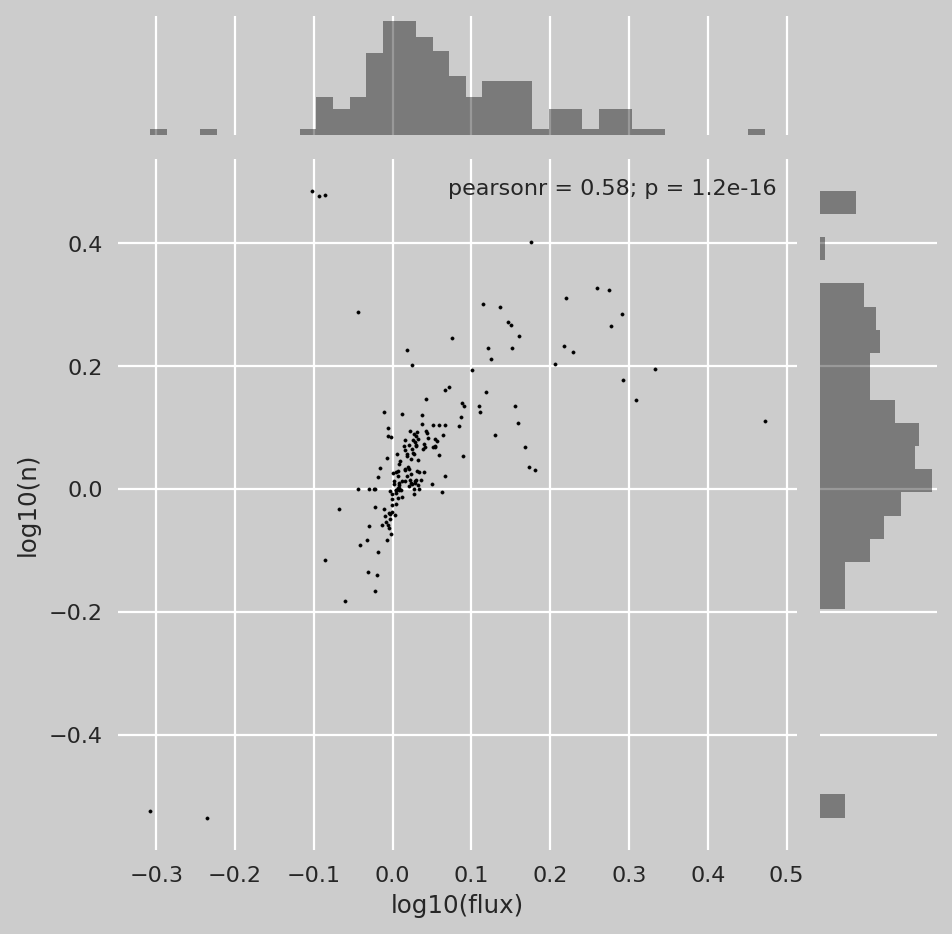

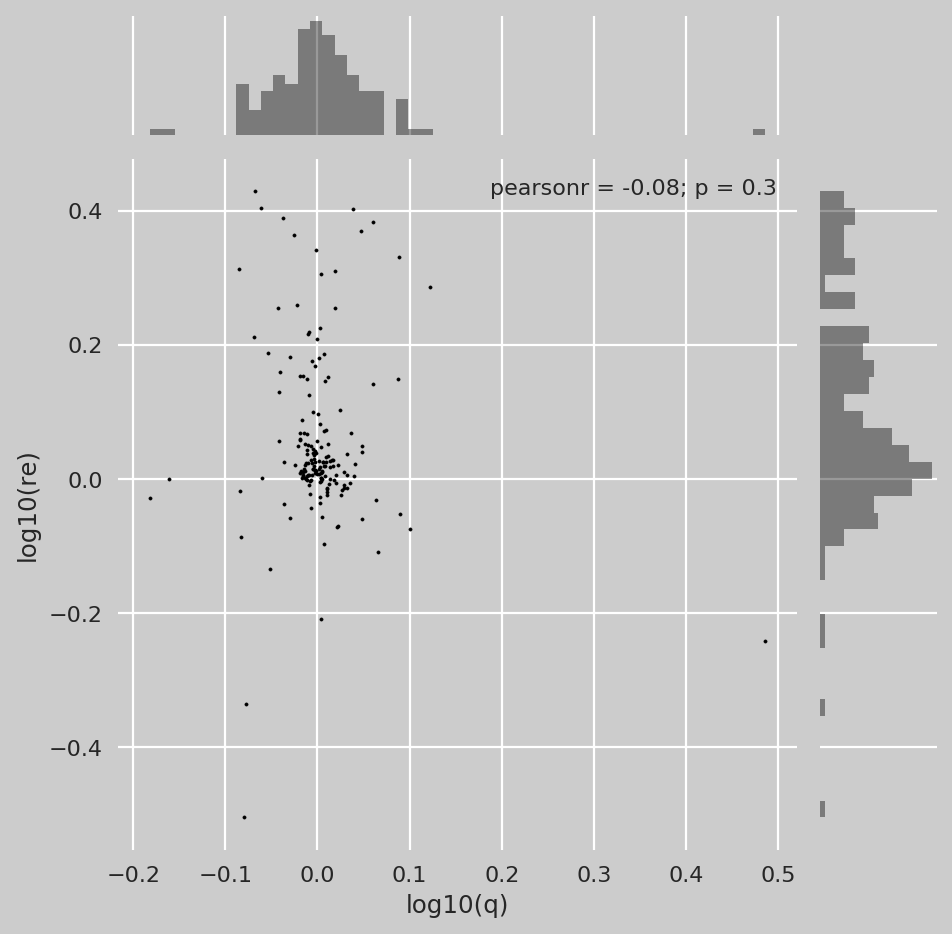

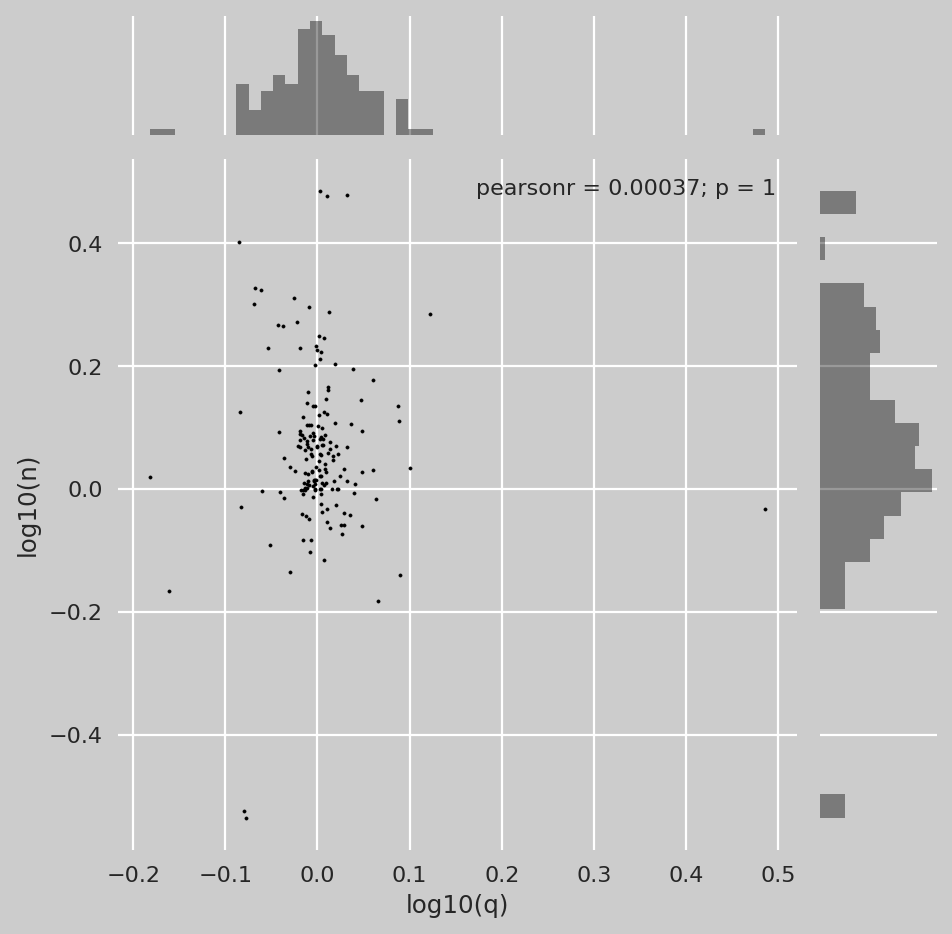

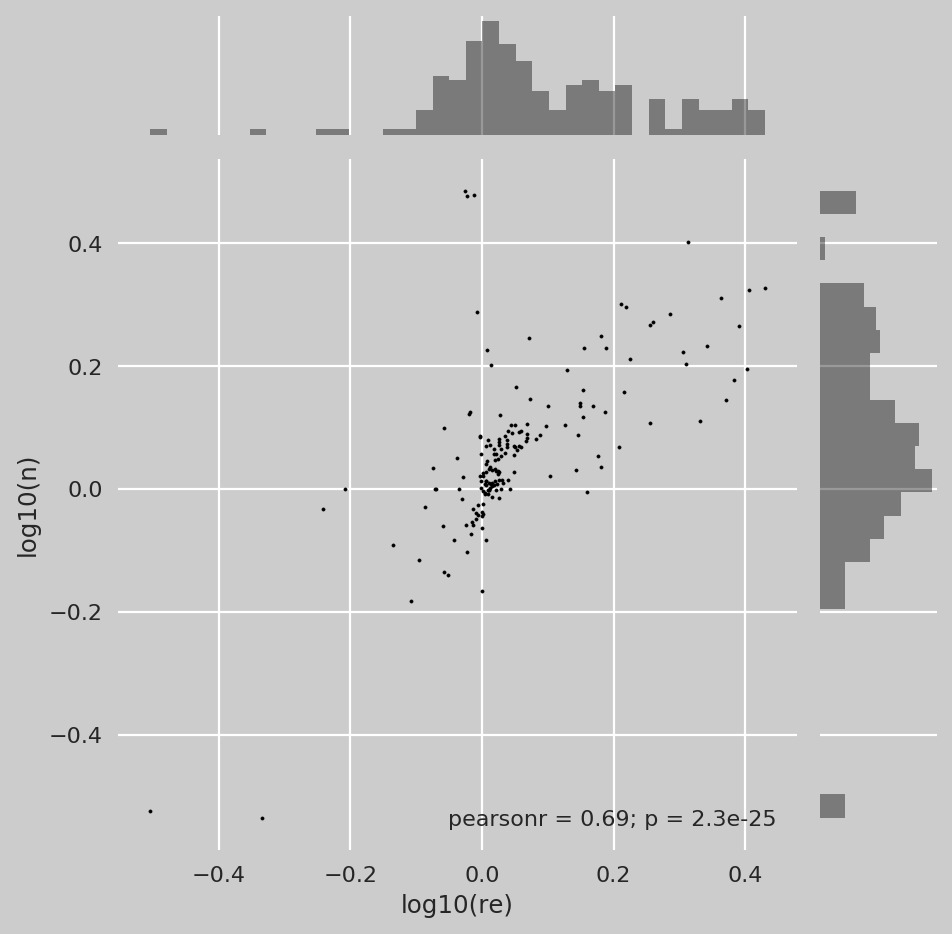

In [24]:
vars = ["flux", "q", "re", "n"]
ratios = {var: tab["profit.ser." + var]/tab["cosmos.ser." + var] for var in vars}
for i, x in enumerate(vars):
    for y in vars[(i+1):(len(vars)+1)]:
        fig = sns.jointplot(
            x=np.log10(ratios[x]),
            y=np.log10(ratios[y]),
            color="k", joint_kws={'marker': '.', 's': 8},
            marginal_kws={'hist_kws': {'log': True}},
        ).set_axis_labels('log10({})'.format(x), 'log10({})'.format(y))

In [162]:
max=np.argmax(ratios["flux"])
print(max)
tab.iloc[max]

65


/usr/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


id                            7.900000e+01
ra                            1.503515e+02
dec                           2.341063e+00
cosmos.IDENT                  1.063024e+06
cosmos.mag_auto               2.453030e+01
cosmos.flux_radius            1.501103e+01
cosmos.zphot                  1.950600e+00
cosmos.use_bulgefit           0.000000e+00
cosmos.viable_sersic          1.000000e+00
profit.gauss.chisqred.0       1.152260e+00
profit.gauss.chisqred.1       1.116126e+00
profit.gauss.time.0           5.446045e-01
profit.gauss.time.1           1.626990e+00
profit.exp.chisqred.0         1.232474e+00
profit.exp.chisqred.1         1.121098e+00
profit.exp.time.0             5.770864e-01
profit.exp.time.1             1.690104e+00
profit.multidev.chisqred.0    1.335063e+00
profit.multidev.chisqred.1    1.286507e+00
profit.multidev.time.0        1.170283e+00
profit.multidev.time.1        2.994621e+00
profit.ser.chisqred.0         1.116114e+00
profit.ser.chisqred.1         1.115974e+00
profit.ser.

In [16]:
modelsprofit = models["single"]["profit"] + models["double"]["profit"] 
chisqredcols = [".".join(["profit", model, "chisqred", "0" if model == "cmodel" else "1"]) for model in modelsprofit]
modelbest = tab[chisqredcols].idxmin(axis=1)
modelbestcounts = modelbest.value_counts()
print(modelbestcounts)

profit.devexp.chisqred.1    95
profit.ser.chisqred.1       68
profit.gauss.chisqred.1      5
profit.cmodel.chisqred.0     5
dtype: int64


In [14]:
tab.iloc[154]

id                               178.000000
ra                               150.385589
dec                                2.540122
cosmos.IDENT                  144964.000000
cosmos.mag_auto                   20.494270
cosmos.flux_radius                13.871647
cosmos.zphot                       0.220000
cosmos.use_bulgefit                0.000000
cosmos.viable_sersic               1.000000
profit.gauss.chisqred.0           31.791007
profit.gauss.chisqred.1            9.496992
profit.gauss.time.0                1.615284
profit.gauss.time.1                2.430540
profit.exp.chisqred.0             14.739925
profit.exp.chisqred.1              5.416970
profit.exp.time.0                  1.889451
profit.exp.time.1                  2.415738
profit.multidev.chisqred.0        10.484070
profit.multidev.chisqred.1         6.440494
profit.multidev.time.0             3.962991
profit.multidev.time.1            11.517673
profit.ser.chisqred.0              5.416970
profit.ser.chisqred.1           